# Utils

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
sns.set()

In [4]:
def plot(Q, actions):
    p_range = list(range(1,22))
    d_range = list(range(1,11))
    v_star = list()
    for p in p_range:
        for d in d_range:
            v_star.append([p, d, np.max([Q[p, d, a] for a in actions])])
            
    df = pd.DataFrame(v_star, columns=['player','dealer','value'])
    
    fig = plt.figure(figsize=(15,15))
    ax = fig.gca(projection='3d')
    ax.plot_trisurf(df['dealer'], df['player'], df['value'], cmap=plt.cm.viridis, linewidth=0.2)
    ax.set_xlabel("Dealer's Hand", fontsize=20)
    ax.set_ylabel("Player's Hand", fontsize=20)
    ax.set_zlabel("P( stick )", fontsize=20)
    #fig.colorbar(surf, shrink=0.5, aspect = 5)
    plt.show()

# Environment

You should write an environment that implements the game Easy21. Specifically, write a function, named step, which takes as input a state s (dealer’s first
card 1–10 and the player’s sum 1–21), and an action a (hit or stick), and returns
a sample of the next state s
0
(which may be terminal if the game is finished)
and reward r. We will be using this environment for model-free reinforcement
learning, and you should not explicitly represent the transition matrix for the
MDP. There is no discounting (γ = 1). You should treat the dealer’s moves as
part of the environment, i.e. calling step with a stick action will play out the
dealer’s cards and return the final reward and terminal state.

In [5]:
import random

class Easy21:
    """
    Be really strict with your implementation relative to the problem criteria 
    """
    def __init__(self, player_threshold=16):
        self.dealer_score, self.player_score = random.choice(list(range(1,11))), random.choice(list(range(1,11)))
        self.terminated = False
        self.reward = 0
        
    def evaluate_winner(self):
        if self.player_score < 1 or self.player_score > 21:
            self.reward = -1
        elif self.dealer_score == self.player_score:
            self.reward = 0
        else:
            self.reward = 1 if self.player_score > self.dealer_score else -1
            
    def update(self, score):
        "Update the state wrt one character"
        colour = random.choice([-1,1,1])
        card = random.choice(list(range(1,11)))
        new_score = score + (colour * card)
        if (new_score > 21 or new_score < 1):
            self.terminated = True
            return new_score
        else:
            return new_score
        
    def play_out_dealer(self):
        "Terminate the game and retrieve the dealer's score"
        if self.reward != -1 and self.terminated == False:
            while self.dealer_score <= 16 and self.dealer_score >= 1: 
                self.dealer_score = self.update(self.dealer_score)
                
        self.terminated = True
        self.evaluate_winner()
        return self.reward, self.dealer_score, self.player_score
    
    def step(self, player_score, dealer_score, action):
        if action == 1:
            self.player_score = self.update(self.player_score)
        else:
            self.play_out_dealer()
        return self.player_score, self.dealer_score, self.reward, self.terminated
    

# Monte-Carlo Control

Apply Monte-Carlo control to Easy21. Initialise the value function to zero. Use
a time-varying scalar step-size of αt = 1/N(st, at) and an -greedy exploration
strategy with t = N0/(N0 + N(st)), where N0 = 100 is a constant, N(s) is
the number of times that state s has been visited, and N(s, a) is the number
of times that action a has been selected from state s. Feel free to choose an
alternative value for N0, if it helps producing better results. Plot the optimal
value function V
∗
(s) = maxa Q∗
(s, a) using similar axes to the following figure
taken from Sutton and Barto’s Blackjack example.

0 -1.0
10000 -0.14878512148785122
20000 -0.12074396280185776
30000 -0.08959701343288445
40000 -0.06417339566510856
50000 -0.0434591308173839
60000 -0.027732871118814652
70000 -0.013314095512921259
80000 -0.001262484218947263
90000 0.008588793457850439
100000 0.016939830601693795
110000 0.023299788183743873
120000 0.029591420071499362
130000 0.035945877339404915
140000 0.041621131277633915
150000 0.04764634902433987
160000 0.05256217148642833
170000 0.056858489067711036
180000 0.06079410669940691
190000 0.06392071620675657
200000 0.06692466537667359
210000 0.06952347845962766
220000 0.07232694396843768
230000 0.07467793618288676
240000 0.07727884467147991
250000 0.07929968280126796
260000 0.0810189191580025
270000 0.08297006307384006
280000 0.08498183935057273
290000 0.08673418367522795


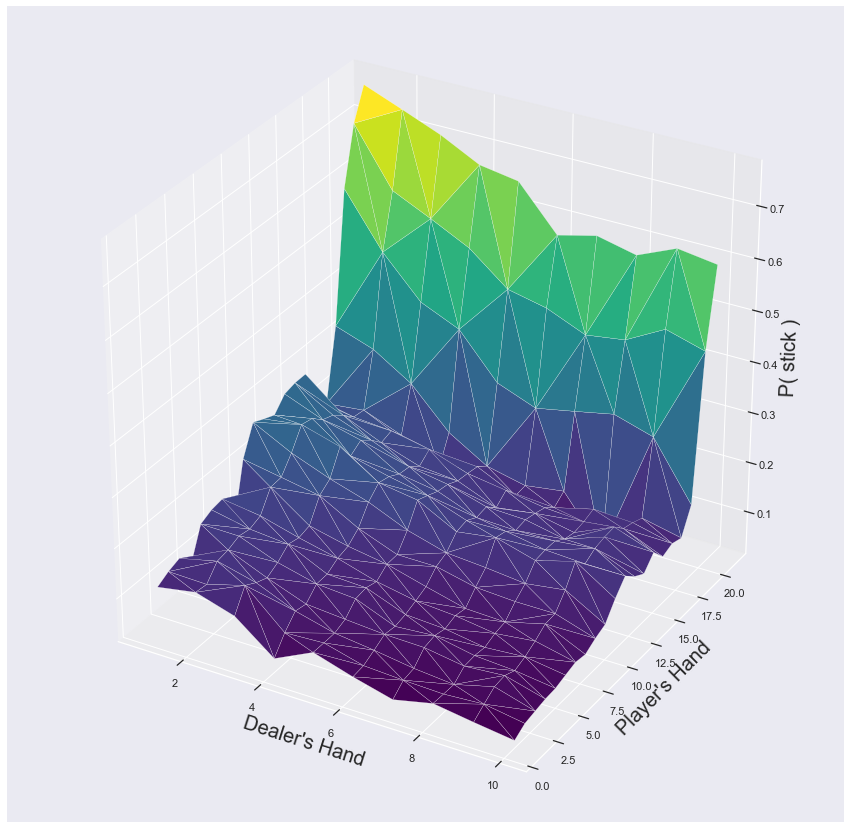

In [6]:
import numpy as np

print_every = 100
actions = [0,1]
N0 = 100

# state, action function
Q = np.zeros((22,11,len(actions)))

# number of times action a has been chosen in state s
NSA = np.zeros((22,11,len(actions)))

# number of times state s has been visited
def NS(p, d):
    return np.sum(NSA[p,d])

# step size
def alpha(p, d, a):
    return 1 / NSA[p, d, a]

# exploration probability -> inversely proportional to the number of times the state has been explored
def epsilon(p, d):
    return N0 / (N0 + NS(p, d))

def epsilon_greedy(p, d):
    if np.random.random() < epsilon(p, d):
        action = np.random.choice(actions)
    else:
        action = np.argmax([Q[p, d, a] for a in actions])
    return action


episodes = int(3e5)
mean_return = 0
wins = 0

for episode in range(episodes):
    terminated = False
    SAR = list()
    env = Easy21()
    while env.terminated == False:
        a = epsilon_greedy(env.player_score, env.dealer_score)
        p, d = env.player_score, env.dealer_score
        NSA[env.player_score, env.dealer_score, a] += 1
        p_prime, d_prime, r, terminated = env.step(env.player_score, env.dealer_score, a)
        SAR.append([p, d, a, r])
        env.player_score, env.dealer_scor = p_prime, d_prime
        
    G = sum([sar[-1] for sar in SAR])
    for (p, d, a, _) in SAR:
        Q[p, d, a] += alpha(p, d, a) * (G - Q[p, d, a])
        
    mean_return = mean_return + 1/(episode + 1) * (G - mean_return)
    if r == 1:
        wins += 1
        
    episode_list, mean_returns, win_list = [], [], []
    if episode % 10000 == 0:
        print(episode, mean_return)
        episode_list.append(episode)
        mean_returns.append(mean_return)
        
plot(Q, [0,1])

# Sarsa(lambda)

## Assignment
Implement Sarsa(λ) in 21s. Initialise the value function to zero. Use the same
step-size and exploration schedules as in the previous section. Run the algorithm
with parameter values λ ∈ {0, 0.1, 0.2, ..., 1}. Stop each run after 1000 episodes
2
and report the mean-squared error P
s,a(Q(s, a) − Q∗
(s, a))2 over all states s
and actions a, comparing the true values Q∗
(s, a) computed in the previous
section with the estimated values Q(s, a) computed by Sarsa. Plot the meansquared error against λ. For λ = 0 and λ = 1 only, plot the learning curve of
mean-squared error against episode number.

## Theory

Monte-Carlo control requires a complete path / play to the end before any update is made. This can make it slow. TD(0) (Temporal = relating to time) is the opposite end of the spectrum where an update occurs after every step/action. SARSA = State-Action-Reward-State-Action. The lambda refers to a geometric decay.

The advantage of TD over Monte Carlo algorithm is that it does not need to wait until the end of each round to update the action value or state value table (e.g. Q The advantage of TD algorithm over dynamic programming is that it does not need an environment model (because the updating rules of dynamic programming algorithm are known by default, that is, the state transition probability is completely known, which is unrealistic in most cases.) https://www.fatalerrors.org/a/q-learning-sars-a-and-sars-a-lambda.html

The algorithm introduces the eligibility trace on the basis of the SARSA algorithm. Intuitively, the explanation is to make the algorithm have a certain memory for the state it has experienced. As described in sutton, the qualification trace has a short-term memory effect on the acquired trajectory.https://www.fatalerrors.org/a/q-learning-sars-a-and-sars-a-lambda.html. The experienced state is no longer deleted directly after it has been experienced, but there is a smooth attenuation transition, which saves a certain degree of information.

TD- λ  uses a discounting factor  λ  to make changes to predictions made further in the past smaller relative to changes in the immediate past. This accounts for any uncertainty about the dynamics of the world and the possibility that the policy being followed is not optimal. https://www.quora.com/What-is-the-difference-between-Q-learning-TD-learning-and-TD-lambda.

SARSA is an on-policy algorithm, hence it improves the same policy which is used for interacting with the environment. The goal is to find the optimal policy (π∗) and an optimal action-value function (q*). https://www.quora.com/What-is-the-difference-between-Q-learning-and-SARSA-learning.

In TD learning you use your value function to estimate the expected return for the rest of the path.

TD(lambda) -> Eligibility used to update value function????
Sarsa(lambda) -> Save eligibility for state-action pairs instead of just states. https://people.cs.umass.edu/~barto/courses/cs687/Chapter%207.pdf

In [36]:
import sys
import itertools

def make_epsilon_greedy_policy(Q, epsilon, nA):
    
    #def policy_fn(observation): # S'?? -> replaces the epsilon greedy use before??
    #    A = np.ones(nA, dtype=float) * epsilon / nA
    #    best_action = np.argmax(Q[observation])
    #    A[best_action] += (1.0 - epsilon)
    #    return A
    
    # nA may just mean number of actions, IT DOES
    def policy_fn(player_score, dealer_score):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[player_score][dealer_score])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn
    
# removed env as an argument
def sarsa_lambda(env, num_episodes, discount=0.9, alpha=0.01, trace_decay=0.9, epsilon=0.1, type='accumulate'):
    
    # Q = the value function
    #Q = np.zeros((22,11,len(actions))) #defaultdict(lambda: np.zeros(env.nA))
    Q = np.zeros((22,11,len(actions)))
    # replaced E with NSA??
    E = np.zeros((22,11,len(actions)))
    # NSA + Q definitely have the same dimensions in the example but I don't understand why?
    
    #E = defaultdict(lambda: np.zeros(env.nA))

    # Still just epsilon greedy under the hood?
    #policy = make_epsilon_greedy_policy(Q, epsilon, env.nA)
    policy = make_epsilon_greedy_policy(Q, epsilon, 2) # nA = number of Actions => not [0,1]

    #stats = plotting.EpisodeStats(
    #    episode_lengths=np.zeros(num_episodes),
    #    episode_rewards=np.zeros(num_episodes)
    #)
    rewards = [0.]
    episode_rewards = {}
    
    for i_episode in range(num_episodes):

        print("\rEpisode {}/{}. ({})".format(i_episode+1, num_episodes, rewards[-1]), end="")
        sys.stdout.flush()

        state = env() # creates the random scores.
        #state = env.reset()
        player_score, dealer_score = state.player_score, state.dealer_score
        action_probs = policy(player_score, dealer_score)
        action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

        for t in itertools.count():

            # clumsy implementation because you've used your class to implement two different styles of algorithm.
            #next_state, reward, done, _ = env.step(env.player_score, env.dealer_score, action) #env.step(action) DONE = TERMINATED
            next_player_score, next_dealer_score, reward, terminated = state.step(player_score, dealer_score, action)
            
            # next_dealer_score may sometimes not work with your implementation which allows the dealer_score to exceed 11 but then corrects it???
            next_action_probs = policy(next_player_score, next_dealer_score)
            next_action = np.random.choice(np.arange(len(next_action_probs)), p=next_action_probs)

            delta = reward + discount * Q[next_player_score][next_dealer_score][next_action] - Q[player_score][dealer_score][action]
            #delta = reward + discount*Q[next_state][next_action] - Q[state][action]

            
            #episode_rewards[i_episode] += reward
            episode_rewards[i_episode] = episode_rewards.get(i_episode,0) + 1

            #E[state][action] += 1
            NSA[player_score][dealer_score][action] += 1
            
            # may have to replace the s with two letters to represent the full state (player_score + dealer_score)
            #for player_score, dealer_score, _ in Q.items():
            #for player_score, dealer_score, X in zip(Q):
            for A in Q:
                print(A.shape)
                Q[player_score][player_score][:] += alpha * delta * NSA[player_score][dealer_score][:]
                if type == 'accumulate':
                    E[player_score][dealer_score][:] *= trace_decay * discount
                elif type == 'replace':
                    if s == state:
                        E[player_score][dealer_score][:] = 1
                    else:
                        E[player_score][dealer_score][:] *= discount * trace_decay

            if terminated:
                break

                
            player_score, dealer_score = next_player_score, next_dealer_score # (this may not be required because of your class design)
            #state = next_state
            action = next_action

    return Q, episode_rewards

Q, episode_rewards = sarsa_lambda(Easy21, num_episodes=100000, discount=0.9, alpha=0.01, trace_decay=0.9, epsilon=0.1, type='accumulate')

Episode 1/100000. (0.0)(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
Episode 2/100000. (0.0)(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
(11, 2)
Episode 3/100000. (0.0)

IndexError: index 21 is out of bounds for axis 0 with size 11